# Metagenomic Classification - Shotgun Sequencing

This notebook trains a classification model on the shotgun sequencing dataset using a 5-mer stride 1 model following the Genomic-ULMFiT procedure. First the general bacterial genomic language model is fine tuned, then the fine tuned model is used to initialize the classification model.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [3]:
sys.path.append("../../..")
from utils import *

In [4]:
path = Path('F:/genome/bacterial genomes/')

# Shotgun LM

In [5]:
classification_df = pd.read_csv(path/'s16_shotgun_sequences.csv')

In [6]:
classification_df.head()

,Sequence,Species,set
0,TTAATACTCTGCTACTGTGACGTTACTCGCAGAAGAAGCACCGGCT...,Gammaproteobacteria Alteromonadales Moritellac...,train
1,CTGCATGGCTGTCGCCAGCTCGTGTTGTGAAATGTTGGGTTAAGTC...,Gammaproteobacteria Alteromonadales Moritellac...,train
2,TACAATGGCGCATACAAAGGGCTGCAAACCAGCAATGGTAAGCGAA...,Gammaproteobacteria Alteromonadales Moritellac...,train
3,TGGGGAATATTGCACAATGGGGGAAACCCTGATGCAGCCATACCGC...,Gammaproteobacteria Alteromonadales Moritellac...,train
4,AAGCGGTGGAGCATGTGGTTTAATTCGATGCAACGCGAAGAACCTT...,Gammaproteobacteria Alteromonadales Moritellac...,train


In [7]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [8]:
train_df.shape, valid_df.shape, test_df.shape

((23493, 3), (1771, 3), (1954, 3))

In [9]:
voc = np.load(path/'bact_vocab_5m1s.npy')
model_vocab = GenomicVocab(voc)

In [10]:
tok = Tokenizer(partial(GenomicTokenizer, ngram=5, stride=1), n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [11]:
data = GenomicTextLMDataBunch.from_df(path, train_df, valid_df, bs=850, tokenizer=tok, 
                              chunksize=10000, text_cols='Sequence', label_cols='Species', vocab=model_vocab)

In [14]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 0.4

In [15]:
learn = get_model_LM(data, drop_mult, config)

In [16]:
learn.load('b1_5m1s');

In [17]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(1025, 400, padding_idx=0)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(1025, 400, padding_idx=0)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=1025, bias=True)
    (output_dp): RNNDropout()
  )
)

In [18]:
learn = learn.to_fp16(dynamic=True);

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


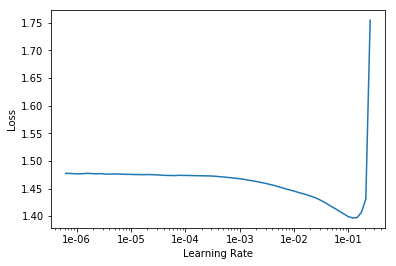

In [21]:
learn.recorder.plot()

# Training


In [22]:
learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.283844,1.106919,0.523809,01:03
1,1.047906,0.948790,0.597750,01:04
2,0.950496,0.907561,0.623708,01:05
3,0.898548,0.872593,0.637286,01:04
4,0.867203,0.852599,0.646061,01:05
5,0.844704,0.839092,0.655672,01:05
6,0.823967,0.826624,0.660721,01:05
7,0.807281,0.820463,0.664635,01:05
8,0.796559,0.816860,0.666227,01:05
9,0.789996,0.816464,0.666053,01:05


In [23]:
learn.save('s16_sg_LM_5m1s')
learn.save_encoder('s16_sg_LM_5m1s_enc')

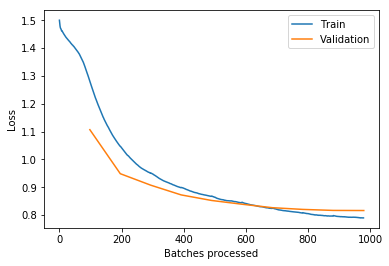

In [24]:
learn.recorder.plot_losses()

# Classification

In [5]:
classification_df = pd.read_csv(path/'s16_shotgun_sequences.csv')

In [6]:
classification_df.head()

,Sequence,Species,set
0,TTAATACTCTGCTACTGTGACGTTACTCGCAGAAGAAGCACCGGCT...,Gammaproteobacteria Alteromonadales Moritellac...,train
1,CTGCATGGCTGTCGCCAGCTCGTGTTGTGAAATGTTGGGTTAAGTC...,Gammaproteobacteria Alteromonadales Moritellac...,train
2,TACAATGGCGCATACAAAGGGCTGCAAACCAGCAATGGTAAGCGAA...,Gammaproteobacteria Alteromonadales Moritellac...,train
3,TGGGGAATATTGCACAATGGGGGAAACCCTGATGCAGCCATACCGC...,Gammaproteobacteria Alteromonadales Moritellac...,train
4,AAGCGGTGGAGCATGTGGTTTAATTCGATGCAACGCGAAGAACCTT...,Gammaproteobacteria Alteromonadales Moritellac...,train


In [7]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [8]:
voc = np.load(path/'bact_vocab_5m1s.npy')
model_vocab = GenomicVocab(voc)

In [9]:
tok = Tokenizer(partial(GenomicTokenizer, ngram=5, stride=1), n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df,
                                             tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Species', bs=400)

In [13]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, 
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.5

In [14]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [15]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(1025, 400, padding_idx=0)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(1025, 400, padding_idx=0)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.

In [15]:
learn.load_encoder('s16_sg_LM_5m1s_enc')
learn.freeze()

In [16]:
learn = learn.to_fp16(dynamic=True);

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


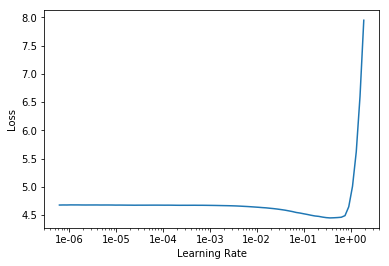

In [17]:
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(10, 5e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.410440,3.931489,0.072840,00:31
1,3.824448,3.019622,0.197628,00:31
2,3.505262,2.636554,0.267081,00:32
3,3.281606,2.382077,0.320723,00:32
4,3.146800,2.239338,0.372106,00:32
5,2.994547,2.020784,0.433089,00:32
6,2.888503,1.940576,0.452287,00:32
7,2.742746,1.794553,0.481084,00:32
8,2.669345,1.750511,0.493506,00:32
9,2.600651,1.724113,0.501976,00:32


In [18]:
learn.freeze_to(-2)
learn.fit_one_cycle(8, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.492471,1.620851,0.533597,00:38
1,2.251090,1.359972,0.579898,00:38
2,1.925900,1.100127,0.635799,00:38
3,1.633607,0.944744,0.676454,00:38
4,1.419420,0.839300,0.710898,00:39
5,1.260666,0.783269,0.728967,00:39
6,1.147372,0.756107,0.733484,00:38
7,1.092577,0.751816,0.736307,00:38


In [19]:
learn.freeze_to(-3)
learn.fit_one_cycle(8, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.060023,0.732602,0.739695,00:59
1,1.042858,0.720604,0.747600,00:59
2,0.987355,0.667561,0.776398,00:59
3,0.922130,0.627243,0.778656,00:59
4,0.861433,0.603030,0.793337,00:59
5,0.806887,0.577375,0.800113,00:59
6,0.769759,0.567541,0.800113,00:59
7,0.735531,0.567201,0.801242,00:59


In [20]:
learn.unfreeze()
learn.fit_one_cycle(8, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.743564,0.564034,0.801807,01:13
1,0.738857,0.561477,0.802372,01:13
2,0.722500,0.547373,0.806324,01:13
3,0.694440,0.518349,0.815359,01:13
4,0.648285,0.504869,0.823828,01:13
5,0.615474,0.494931,0.824958,01:13
6,0.583926,0.487689,0.823828,01:13
7,0.568340,0.485695,0.825522,01:13


In [21]:
learn.fit_one_cycle(12, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.571757,0.483934,0.828346,01:12
1,0.571093,0.486612,0.828346,01:13
2,0.574719,0.484265,0.832863,01:13
3,0.569285,0.475553,0.835121,01:13
4,0.547816,0.470830,0.848108,01:13
5,0.523213,0.447241,0.847544,01:13
6,0.503476,0.442865,0.851496,01:13
7,0.482634,0.426384,0.857143,01:12
8,0.455784,0.426416,0.856014,01:12
9,0.436240,0.423244,0.857143,01:13


In [22]:
learn.save('metagenomic_sg_genus_finetune_5m1s')

In [12]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, 
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.4

In [13]:
learn = get_model_clas(data_clas, drop_mult, clas_config)
learn = learn.to_fp16(dynamic=True);

In [14]:
learn.load('metagenomic_sg_genus_finetune_5m1s');
learn.unfreeze()

In [15]:
learn.fit_one_cycle(12, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.330636,0.416005,0.862789,01:13
1,0.330484,0.412595,0.858837,01:13
2,0.324144,0.409577,0.857708,01:14
3,0.323346,0.403580,0.860531,01:13
4,0.318091,0.401407,0.862225,01:13
5,0.312158,0.399128,0.862225,01:13
6,0.310165,0.397658,0.861660,01:13
7,0.300390,0.396203,0.862225,01:13
8,0.297088,0.397680,0.861660,01:14
9,0.289377,0.395910,0.863919,01:13


In [16]:
learn.save('metagenomic_sg_genus_finetune_5m1s_2')

In [16]:
learn.load('metagenomic_sg_genus_finetune_5m1s_2');

In [17]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, test_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Species', bs=400)
learn.data = data_clas

In [18]:
preds = learn.get_preds()

In [19]:
p = torch.argmax(preds[0], dim=1)

In [24]:
precision_score(preds[1], p, average='macro')

0.8631918223650911

In [25]:
recall_score(preds[1], p, average='macro')

0.8566150338306044

In [26]:
accuracy_score(preds[1], p)

0.8582395087001023

In [27]:
f1_score(preds[1], p, average='macro')

0.8569451426337931

In [22]:
pred_df = pd.DataFrame(preds[1], columns=['gt_int'])

In [23]:
pred_df['gt_name'] = pred_df.gt_int.map(lambda x: data_clas.classes[x])

In [24]:
pred_df['predicted_int'] = p
pred_df['predicted_name'] = pred_df.predicted_int.map(lambda x: data_clas.classes[x])

In [25]:
pred_df.gt_name = pred_df.gt_name.map(lambda x: ' '.join(x.split('_', 1)) if len(x.split()) == 3 else x)

In [26]:
pred_df.predicted_name = pred_df.predicted_name.map(lambda x: ' '.join(x.split('_', 1)) if len(x.split()) == 3 else x)

In [28]:
taxa_list = ['Class', 'Order', 'Family', 'Genus']
for i, taxa in enumerate(taxa_list):
    print(taxa)
    print((pred_df.gt_name.map(lambda x: x.split()[i]) == pred_df.predicted_name.map(lambda x: x.split()[i])).mean())
    print('\n')

Class
0.9969293756397134


Order
0.9795291709314228


Family
0.9626407369498464


Genus
0.8582395087001023


